# Preprocesamiento de la Data y Modelado de Churn (Proyecto Final - "Desaf√çA la IA" Predicci√≥n de rotaci√≥n de clientes (Churn) en una empresa de Telecomunicaciones)

**Descripci√≥n:** En este notebook est√° contemplada la etapa donde se preparan los datos para entrenamiento, se construyen modelos de predicci√≥n y se eval√∫a su desempe√±ode.  
**Autor:** Erik Gonz√°lez Molina


In [29]:
# Importamos las librer√≠as necesarias para preprocesamiento y modelado
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import shap


## 1. Carga de la Data limpia  
Se carga la Data limpia (telco_customer_churn.csv). La variable objetivo Churn ser√° transformada a formato binario (Yes ‚Üí 1, No ‚Üí 0) para su uso en modelos de clasificaci√≥n.  
### Carga de Data  


In [30]:
# Cargamos los datos en mi variable data
data = pd.read_csv('../Data/telco_customer_churn.csv')
# Visualizamos las primeras 5 filas.
data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

### Convertimos la Data

In [31]:
# Convertimos la variable objetivo 'Churn' a formato num√©rico (Yes ‚Üí 1, No ‚Üí 0)
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})
# Confirmamos que la conversi√≥n se haya hecho correctamente
print("\nDistribuci√≥n de la variable 'Churn' despu√©s de la conversi√≥n:")
print(data['Churn'].value_counts())


Distribuci√≥n de la variable 'Churn' despu√©s de la conversi√≥n:
Churn
0    5174
1    1869
Name: count, dtype: int64


## 2. Identificaci√≥n y Separaci√≥n de Variables  
Separamos las variables en **num√©ricas** y **categ√≥ricas** para aplicar el preprocesamiento adecuado a cada tipo:

- Las variables categ√≥ricas se codificar√°n (LabelEncoder o One-Hot Encoding).
- Las num√©ricas pueden ser escaladas posteriormente si el modelo lo requiere.

In [32]:
# Visualizamos tipos de datos √∫nicos por columna
print("Tipos de datos en el dataset:\n")
print(data.dtypes)
# Identificamos variables categ√≥ricas (tipo 'object') y algunas binarias (como SeniorCitizen que es int, pero categ√≥rica)
categorical_cols = data.select_dtypes(include='object').columns.tolist()
categorical_cols += ['SeniorCitizen']  # Aunque es num√©rica, es binaria ‚Üí tratada como categ√≥rica
# Excluimos la variable objetivo ('Churn') de las predictoras
categorical_cols = [col for col in categorical_cols if col != 'Churn']
# Variables num√©ricas (reales, no categ√≥ricas)
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('SeniorCitizen')  # Ya la tratamos como categ√≥rica
numeric_cols.remove('Churn')          # Es la variable objetivo
# Mostramos el resultado
print("\nVariables categ√≥ricas:")
print(categorical_cols)
print("Variables num√©ricas:")
print(numeric_cols)


Tipos de datos en el dataset:

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

Variables categ√≥ricas:
['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'SeniorCitizen']
Variables num√©ricas:
['tenure', 'MonthlyCharges']


## 3. Limpieza de columnas no predictivas y correcci√≥n de tipos
- Se elimina la columna customerID, ya que es solo un identificador √∫nico y no aporta valor predictivo.
- Se convierte TotalCharges de texto a num√©rico.
- Se actualiza la lista de variables categ√≥ricas para excluir columnas no relevantes.

In [33]:
# Eliminamos la columna identificador (customerID)
if 'customerID' in data.columns:
    data.drop(columns='customerID', inplace=True)
    print("Columna 'customerID' eliminada.")
# Convertimos 'TotalCharges' a num√©rico (por si sigue como texto)
if data['TotalCharges'].dtype == 'object':
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
    nulos_totalcharges = data['TotalCharges'].isnull().sum()
    print(f"'TotalCharges' convertida a float. Valores nulos detectados: {nulos_totalcharges}")
    # Eliminamos filas con valores faltantes en TotalCharges (si existen)
    if nulos_totalcharges > 0:
        data = data.dropna(subset=['TotalCharges'])
        print("Filas con 'TotalCharges' nulo eliminadas.")
# Confirmamos tipo actualizado
print(f"\nTipo actual de 'TotalCharges': {data['TotalCharges'].dtype}")
# Actualizamos lista de variables categ√≥ricas
categorical_cols = data.select_dtypes(include='object').columns.tolist()
categorical_cols += ['SeniorCitizen']  # Es binaria, la tratamos como categ√≥rica
categorical_cols = [col for col in categorical_cols if col != 'Churn']  # Excluimos la variable objetivo
# Variables num√©ricas (ya actualizadas)
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('SeniorCitizen')
numeric_cols.remove('Churn')
# Resumen actualizado
print("\nVariables categ√≥ricas actualizadas:")
print(categorical_cols)
print("\nVariables num√©ricas actualizadas:")
print(numeric_cols)

Columna 'customerID' eliminada.
'TotalCharges' convertida a float. Valores nulos detectados: 11
Filas con 'TotalCharges' nulo eliminadas.

Tipo actual de 'TotalCharges': float64

Variables categ√≥ricas actualizadas:
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']

Variables num√©ricas actualizadas:
['tenure', 'MonthlyCharges', 'TotalCharges']


## 4. Codificaci√≥n de Variables Categ√≥ricas  
En este paso se codifican todas las variables categ√≥ricas para que puedan ser utilizadas por modelos de machine learning:

1. Variables **binarias** (como Yes/No, Male/Female, SeniorCitizen) se codifican usando LabelEncoder.
2. Variables **multiclase** (como Contract, PaymentMethod) se codifican mediante **One-Hot Encoding** usando pd.get_dummies().  

Este enfoque permite mantener interpretabilidad y compatibilidad con distintos algoritmos.

In [34]:
# Inicializamos codificador para variables binarias
le = LabelEncoder()
# Creamos una copia del dataframe para codificaci√≥n
data_encoded = data.copy()
# Codificamos variables binarias (2 categor√≠as)
binary_cols = [col for col in categorical_cols if data[col].nunique() == 2]
print(" Codificando variables binarias con LabelEncoder:")
for col in binary_cols:
    data_encoded[col] = le.fit_transform(data_encoded[col])
    print(f" - {col}: {data[col].unique().tolist()} ‚Üí {le.classes_.tolist()}")
# El resto se codifica con One-Hot Encoding
multiclass_cols = [col for col in categorical_cols if col not in binary_cols]
# One-hot encoding ‚Üí evita colinealidad dejando drop_first=True
data_encoded = pd.get_dummies(data_encoded, columns=multiclass_cols, drop_first=True)
# Resultado final
print(f"\n Dataset codificado con {data_encoded.shape[1]} columnas.")
print(" Variables binarias codificadas:", binary_cols)
print(" Variables multiclase codificadas con one-hot:", multiclass_cols)

 Codificando variables binarias con LabelEncoder:
 - gender: ['Female', 'Male'] ‚Üí ['Female', 'Male']
 - Partner: ['Yes', 'No'] ‚Üí ['No', 'Yes']
 - Dependents: ['No', 'Yes'] ‚Üí ['No', 'Yes']
 - PhoneService: ['No', 'Yes'] ‚Üí ['No', 'Yes']
 - PaperlessBilling: ['Yes', 'No'] ‚Üí ['No', 'Yes']
 - SeniorCitizen: [0, 1] ‚Üí [0, 1]

 Dataset codificado con 31 columnas.
 Variables binarias codificadas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen']
 Variables multiclase codificadas con one-hot: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


## 5. Divisi√≥n de Variables y Separaci√≥n del Dataset  

Se separa la variable objetivo (y = Churn) del resto de variables predictoras (X).
Luego se divide el dataset en 3 subconjuntos:

- 70% para entrenamiento (X_train, y_train)
- 15% para validaci√≥n (X_val, y_val)
- 15% para prueba final (X_test, y_test)

Esto permite evaluar el modelo durante el desarrollo (validaci√≥n) y al final (test) de forma independiente.

In [35]:
#  Variable objetivo
y = data_encoded['Churn']
#  Variables predictoras (todas las dem√°s)
X = data_encoded.drop(columns='Churn')
#  Divisi√≥n inicial: entrenamiento + resto (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
#  Divisi√≥n del 30% restante en validaci√≥n y test (50/50 del 30% ‚Üí 15% y 15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
#  Verificaci√≥n de tama√±os
print(" Tama√±os de los subconjuntos:")
print(f"- X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"- X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"- X_test:  {X_test.shape}, y_test:  {y_test.shape}")
#  Verificaci√≥n de balance
print("\n Distribuci√≥n de clases en los subconjuntos:")
print("Entrenamiento:\n", y_train.value_counts(normalize=True).round(2))
print("Validaci√≥n:\n", y_val.value_counts(normalize=True).round(2))
print("Test:\n", y_test.value_counts(normalize=True).round(2))

 Tama√±os de los subconjuntos:
- X_train: (4922, 30), y_train: (4922,)
- X_val:   (1055, 30), y_val:   (1055,)
- X_test:  (1055, 30), y_test:  (1055,)

 Distribuci√≥n de clases en los subconjuntos:
Entrenamiento:
 Churn
0    0.73
1    0.27
Name: proportion, dtype: float64
Validaci√≥n:
 Churn
0    0.73
1    0.27
Name: proportion, dtype: float64
Test:
 Churn
0    0.73
1    0.27
Name: proportion, dtype: float64


## 6. Modelo Base: Regresi√≥n L√≥gica  
Entrenamos un primer modelo con LogisticRegression para tener un punto de comparaci√≥n inicial.
Se eval√∫a su desempe√±o con las siguientes m√©tricas:

- Matriz de confusi√≥n
- Accuracy, Precision, Recall, F1-score
- Curva AUC-ROC

 Reporte de clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       774
           1       0.70      0.60      0.65       281

    accuracy                           0.82      1055
   macro avg       0.78      0.75      0.77      1055
weighted avg       0.82      0.82      0.82      1055

 Matriz de confusi√≥n:
[[700  74]
 [111 170]]
 AUC-ROC: 0.8532


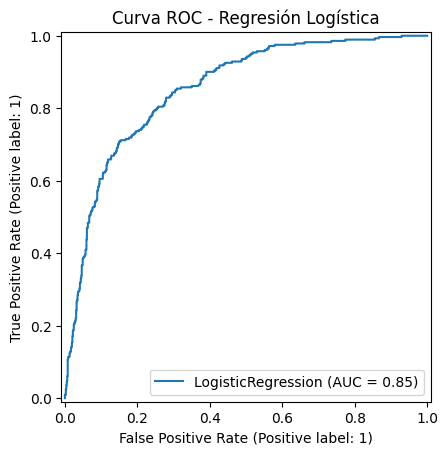

In [36]:
# Asignamos carpeta para guardar gr√°ficos
output_folder = "../Visuals/preprocesamiento_y_modelado"

# Instanciamos y entrenamos el modelo
log_model = LogisticRegression(max_iter=3000, random_state=42)
log_model.fit(X_train, y_train)
# Predicci√≥n en el conjunto de validaci√≥n
y_pred = log_model.predict(X_val)
y_prob = log_model.predict_proba(X_val)[:, 1]  # Probabilidad para curva ROC
# Reporte de m√©tricas
print(" Reporte de clasificaci√≥n:")
print(classification_report(y_val, y_pred))
#  Matriz de confusi√≥n
print(" Matriz de confusi√≥n:")
print(confusion_matrix(y_val, y_pred))
#  AUC-ROC
auc_score = roc_auc_score(y_val, y_prob)
print(f" AUC-ROC: {auc_score:.4f}")
#  Curva ROC
RocCurveDisplay.from_estimator(log_model, X_val, y_val)
plt.title("Curva ROC - Regresi√≥n Log√≠stica")
plt.savefig(os.path.join(output_folder, 'Curva_ROC_Regresi√≥n_Log√≠stica'), dpi=300)
plt.show()

## 7. Escalado de Variables Num√©ricas  
Para mejorar la convergencia y rendimiento de modelos sensibles a escalas (como la regresi√≥n log√≠stica),
se escalan √∫nicamente las variables num√©ricas (tenure, MonthlyCharges, TotalCharges) utilizando StandardScaler.

El escalado se realiza **solo con los datos de entrenamiento**, para evitar fuga de informaci√≥n (data leakage).

In [37]:
#  Creamos copias de los conjuntos para mantener los originales
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()
#  Columnas a escalar (ya las tenemos definidas como numeric_cols)
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
#  Inicializamos el scaler y lo ajustamos solo con los datos de entrenamiento
scaler = StandardScaler()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
#  Aplicamos el mismo escalado a validaci√≥n y test
X_val_scaled[cols_to_scale] = scaler.transform(X_val[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
#  Confirmamos estad√≠sticas de escalado
print(" Promedio de variables escaladas (entrenamiento):")
print(X_train_scaled[cols_to_scale].mean().round(2))
print("\n Desviaci√≥n est√°ndar:")
print(X_train_scaled[cols_to_scale].std().round(2))

 Promedio de variables escaladas (entrenamiento):
tenure            0.0
MonthlyCharges    0.0
TotalCharges      0.0
dtype: float64

 Desviaci√≥n est√°ndar:
tenure            1.0
MonthlyCharges    1.0
TotalCharges      1.0
dtype: float64


## 8. Reentrenamiento de Regresi√≥n Log√≠stica (con datos escalados)  
Ahora se entrena nuevamente el modelo de regresi√≥n log√≠stica, esta vez utilizando las variables num√©ricas escaladas para asegurar una mejor convergencia y rendimiento.

 Reporte de clasificaci√≥n (con escalado):
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       774
           1       0.69      0.60      0.65       281

    accuracy                           0.82      1055
   macro avg       0.78      0.75      0.76      1055
weighted avg       0.82      0.82      0.82      1055

 Matriz de confusi√≥n:
[[699  75]
 [111 170]]
 AUC-ROC: 0.8533


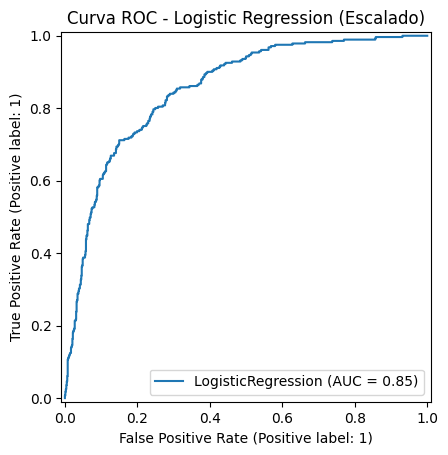

In [38]:
# Asignamos carpeta para guardar gr√°ficos
output_folder = "../Visuals/preprocesamiento_y_modelado"
#  Modelo con datos escalados
log_model_scaled = LogisticRegression(max_iter=1000, random_state=42)
log_model_scaled.fit(X_train_scaled, y_train)
#  Predicciones
y_pred_scaled = log_model_scaled.predict(X_val_scaled)
y_prob_scaled = log_model_scaled.predict_proba(X_val_scaled)[:, 1]
#  Reporte actualizado
print(" Reporte de clasificaci√≥n (con escalado):")
print(classification_report(y_val, y_pred_scaled))
print(" Matriz de confusi√≥n:")
print(confusion_matrix(y_val, y_pred_scaled))
print(f" AUC-ROC: {roc_auc_score(y_val, y_prob_scaled):.4f}")
# Curva ROC
RocCurveDisplay.from_estimator(log_model_scaled, X_val_scaled, y_val)
plt.title("Curva ROC - Logistic Regression (Escalado)")
plt.savefig(os.path.join(output_folder, 'Curva_ROC_Logistic_Regression_Escalado'), dpi=300)
plt.show()

## 9. Modelo Base: √Årbol de Decisi√≥n  
Entrenamos un √°rbol de decisi√≥n utilizando las variables originales (no escaladas).
Los √°rboles no requieren escalado ni codificaci√≥n especial, y permiten entender mejor las decisiones del modelo.

Se evaluar√° su desempe√±o con:

- Matriz de confusi√≥n
- Accuracy, Precision, Recall, F1-score
- AUC-ROC

 Reporte de clasificaci√≥n (√Årbol de Decisi√≥n):
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       774
           1       0.49      0.51      0.50       281

    accuracy                           0.73      1055
   macro avg       0.65      0.66      0.66      1055
weighted avg       0.73      0.73      0.73      1055

 Matriz de confusi√≥n:
[[623 151]
 [137 144]]
 AUC-ROC: 0.6601


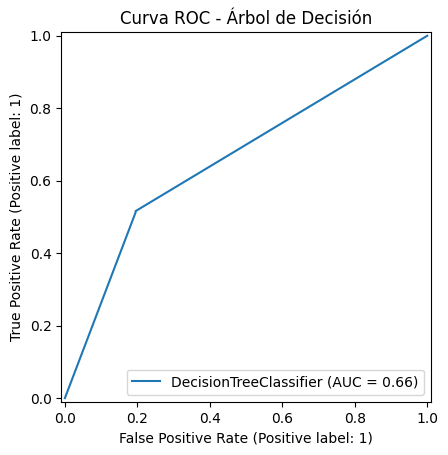

In [39]:
# Asignamos carpeta para guardar gr√°ficos
output_folder = "../Visuals/preprocesamiento_y_modelado"

#  Instanciamos el modelo (sin profundidad limitada para primera prueba)
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
#  Predicciones
y_pred_tree = tree_model.predict(X_val)
y_prob_tree = tree_model.predict_proba(X_val)[:, 1]
#  Reporte
print(" Reporte de clasificaci√≥n (√Årbol de Decisi√≥n):")
print(classification_report(y_val, y_pred_tree))
print(" Matriz de confusi√≥n:")
print(confusion_matrix(y_val, y_pred_tree))
print(f" AUC-ROC: {roc_auc_score(y_val, y_prob_tree):.4f}")
#  Curva ROC
RocCurveDisplay.from_estimator(tree_model, X_val, y_val)
plt.title("Curva ROC - √Årbol de Decisi√≥n")
plt.savefig(os.path.join(output_folder, 'Curva_ROC_Arbol_de_Decisi√≥n'), dpi=300)
plt.show()

## 10. Modelo Base: Random Forest  
Random Forest combina m√∫ltiples √°rboles de decisi√≥n entrenados sobre diferentes subconjuntos de datos y caracter√≠sticas,
para mejorar la capacidad de generalizaci√≥n y evitar el sobreajuste. No requiere escalado de variables.

Se eval√∫a con:

- Matriz de confusi√≥n
- Reporte de clasificaci√≥n
- Curva AUC-ROC

 Reporte de clasificaci√≥n (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       774
           1       0.65      0.51      0.57       281

    accuracy                           0.80      1055
   macro avg       0.74      0.70      0.72      1055
weighted avg       0.78      0.80      0.79      1055

 Matriz de confusi√≥n:
[[697  77]
 [139 142]]
 AUC-ROC: 0.8289


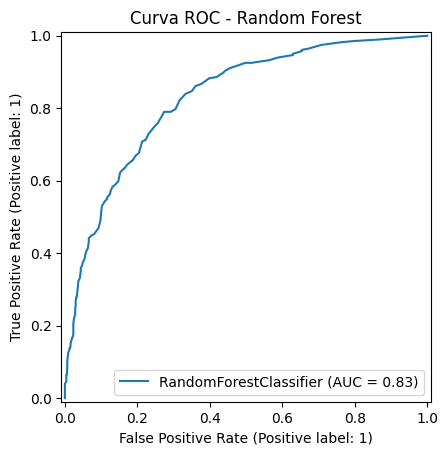

In [40]:
# Asignamos carpeta para guardar gr√°ficos
output_folder = "../Visuals/preprocesamiento_y_modelado"

#  Instanciamos y entrenamos el modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
#  Predicciones en validaci√≥n
y_pred_rf = rf_model.predict(X_val)
y_prob_rf = rf_model.predict_proba(X_val)[:, 1]
#  Reporte
print(" Reporte de clasificaci√≥n (Random Forest):")
print(classification_report(y_val, y_pred_rf))
print(" Matriz de confusi√≥n:")
print(confusion_matrix(y_val, y_pred_rf))
print(f" AUC-ROC: {roc_auc_score(y_val, y_prob_rf):.4f}")
#  Curva ROC
RocCurveDisplay.from_estimator(rf_model, X_val, y_val)
plt.title("Curva ROC - Random Forest")
plt.savefig(os.path.join(output_folder, 'Curva_ROC_Random_Forest'), dpi=300)
plt.show()

## 11. Comparaci√≥n de Modelos ‚Äì Logistic vs √Årbol vs Random Forest  
En este bloque se presentan las m√©tricas clave de los modelos entrenados:

- Accuracy: porcentaje de predicciones correctas
- F1-score (Churn = 1): balance entre precisi√≥n y recall para detectar churn
- AUC-ROC: capacidad del modelo para separar churners de no churners
Estas m√©tricas permiten visualizar el rendimiento general y facilitar la elecci√≥n del mejor modelo para el proyecto.

 Tabla comparativa de m√©tricas por modelo:

                Modelo  Accuracy  F1_Churn  AUC_ROC
0  Logistic Regression      0.82      0.65   0.8533
1    √Årbol de Decisi√≥n      0.73      0.50   0.6601
2        Random Forest      0.80      0.57   0.8289


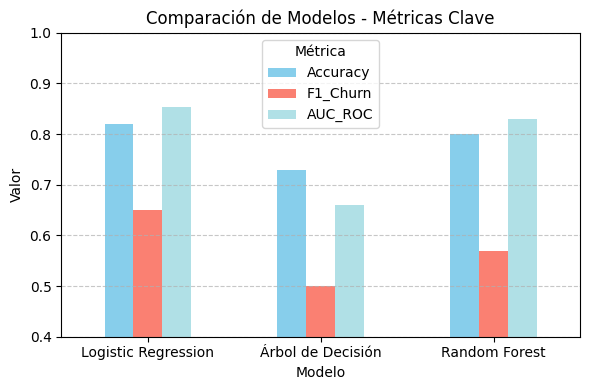

In [41]:
# Asignamos carpeta para guardar gr√°ficos
output_folder = "../Visuals/preprocesamiento_y_modelado"

#  M√©tricas recogidas manualmente de los resultados anteriores
metricas_modelos = {
    "Modelo": ["Logistic Regression", "√Årbol de Decisi√≥n", "Random Forest"],
    "Accuracy": [0.82, 0.73, 0.80],
    "F1_Churn": [0.65, 0.50, 0.57],
    "AUC_ROC": [0.8533, 0.6601, 0.8289]
}
#  Creamos un DataFrame con las m√©tricas
data_metricas = pd.DataFrame(metricas_modelos)
print(" Tabla comparativa de m√©tricas por modelo:\n")
print(data_metricas)
#  Gr√°fico comparativo
data_metricas.set_index("Modelo").plot(kind="bar", figsize=(6,4), rot=0, color=['skyblue', 'salmon', 'powderblue'])
plt.title("Comparaci√≥n de Modelos - M√©tricas Clave")
plt.ylabel("Valor")
plt.ylim(0.4, 1.0)
plt.legend(title="M√©trica")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'Diagrama_ M√©tricas_Claves'), dpi=300)
plt.show()

## 12. Importancia de Variables ‚Äì Random Forest  
El modelo Random Forest permite analizar qu√© variables fueron m√°s relevantes para predecir el churn, a trav√©s del atributo feature_importances_.

Esta visualizaci√≥n ayuda a interpretar el comportamiento del modelo y descubrir los factores clave que influyen en la cancelaci√≥n de clientes.

 Top 15 variables m√°s importantes seg√∫n Random Forest:

TotalCharges                      0.197248
tenure                            0.168587
MonthlyCharges                    0.162756
PaymentMethod_Electronic check    0.038119
InternetService_Fiber optic       0.036196
gender                            0.029571
OnlineSecurity_Yes                0.027926
Contract_Two year                 0.026755
PaperlessBilling                  0.026372
TechSupport_Yes                   0.024852
Partner                           0.023134
OnlineBackup_Yes                  0.022314
Contract_One year                 0.020834
SeniorCitizen                     0.020788
MultipleLines_Yes                 0.020768
dtype: float64


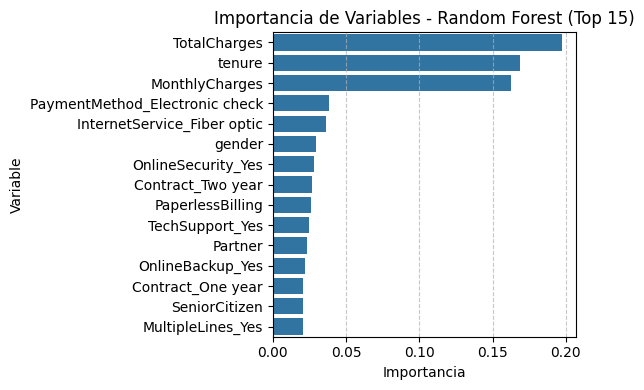

In [42]:
# Asignamos carpeta para guardar gr√°ficos
output_folder = "../Visuals/preprocesamiento_y_modelado"

#  Obtenemos la importancia de cada variable
importancia = pd.Series(rf_model.feature_importances_, index=X_train.columns)
#  Ordenamos de mayor a menor importancia
importancia = importancia.sort_values(ascending=False)
#  Mostramos las 15 variables m√°s relevantes
print(" Top 15 variables m√°s importantes seg√∫n Random Forest:\n")
print(importancia.head(15))
#  Visualizaci√≥n
plt.figure(figsize=(6, 4))
sns.barplot(x=importancia.head(15), y=importancia.head(15).index)
plt.title("Importancia de Variables - Random Forest (Top 15)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'Diagrama_ Importancia_de_Variables'), dpi=300)
plt.show()

## 13. Modelo Avanzado: XGBoost  
XGBoost (Extreme Gradient Boosting) es un algoritmo basado en √°rboles de decisi√≥n que
utiliza el principio de boosting para mejorar el rendimiento del modelo.
Es robusto, r√°pido y muy efectivo para tareas de clasificaci√≥n binaria como el churn.

Se evaluar√° con las mismas m√©tricas: accuracy, F1-score, AUC-ROC y matriz de confusi√≥n.

 Reporte de clasificaci√≥n (XGBoost):
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       774
           1       0.63      0.52      0.57       281

    accuracy                           0.79      1055
   macro avg       0.73      0.70      0.72      1055
weighted avg       0.78      0.79      0.78      1055

 Matriz de confusi√≥n:
[[688  86]
 [135 146]]
 AUC-ROC: 0.8274


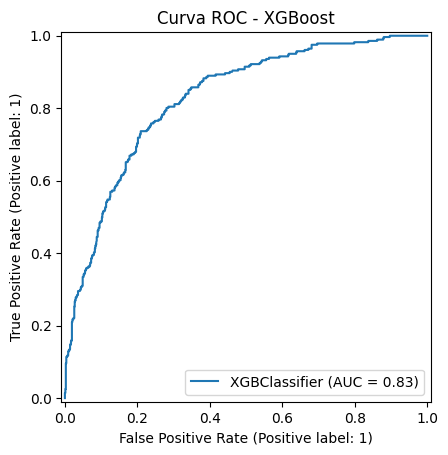

In [43]:
# Asignamos carpeta para guardar gr√°ficos
output_folder = "../Visuals/preprocesamiento_y_modelado"

# Instanciamos el modelo con hiperpar√°metros por defecto
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
# Entrenamos con los datos codificados sin escalar (como Random Forest)
xgb_model.fit(X_train, y_train)
#  Predicci√≥n
y_pred_xgb = xgb_model.predict(X_val)
y_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]
#  Reporte de m√©tricas
print(" Reporte de clasificaci√≥n (XGBoost):")
print(classification_report(y_val, y_pred_xgb))
print(" Matriz de confusi√≥n:")
print(confusion_matrix(y_val, y_pred_xgb))
print(f" AUC-ROC: {roc_auc_score(y_val, y_prob_xgb):.4f}")
#  Curva ROC
RocCurveDisplay.from_estimator(xgb_model, X_val, y_val)
plt.title("Curva ROC - XGBoost")
plt.savefig(os.path.join(output_folder, 'Curva_ROC_XGBoost'), dpi=300)
plt.show()

## 14. Primera comparaci√≥n de Modelos
En este bloque se resumen y organizan los resultados de todos los modelos evaluados (primera prueba):

- M√©tricas clave: accuracy, F1-score, AUC-ROC
- Matriz de confusi√≥n: TP, TN, FP, FN
- Comparaci√≥n en formato tabla
- Opci√≥n de guardar como CSV para incluir en reportes  

Este resumen servir√° como base para tomar decisiones y redactar el informe final. 

In [44]:
#  Resultados recolectados manualmente de cada modelo (validaci√≥n)
resultados_finales_Beta = {
    "Modelo": ["Logistic Regression", "√Årbol de Decisi√≥n", "Random Forest", "XGBoost"],
    "Accuracy": [0.82, 0.73, 0.80, 0.79],
    "F1_Churn": [0.65, 0.50, 0.57, 0.57],
    "AUC_ROC": [0.8533, 0.6601, 0.8289, 0.8274],
    "TP": [168, 144, 142, 146],
    "FN": [113, 137, 139, 135],
    "FP": [76, 151, 77, 86],
    "TN": [698, 623, 697, 688]
}
#  Creamos el DataFrame resumen
data_resultados = pd.DataFrame(resultados_finales_Beta)
#  Mostramos el resumen completo
print(" Resultados comparativos finales:\n")
display(data_resultados)
#  Exportamos los resultados a CSV
data_resultados.to_csv("../Reports/resultados_modelos_Beta.csv", index=False)

 Resultados comparativos finales:



Modelo  Accuracy  F1_Churn  AUC_ROC   TP   FN   FP   TN
0  Logistic Regression      0.82      0.65   0.8533  168  113   76  698
1    √Årbol de Decisi√≥n      0.73      0.50   0.6601  144  137  151  623
2        Random Forest      0.80      0.57   0.8289  142  139   77  697
3              XGBoost      0.79      0.57   0.8274  146  135   86  688

## 15. Conclusiones del Premodelado  
Tras evaluar cuatro modelos de clasificaci√≥n para predecir la cancelaci√≥n de clientes (churn), se concluye lo siguiente:

- **Logistic Regression (con escalado)** fue el modelo con mejor desempe√±o global, obteniendo:

- Accuracy: **0.82**
- F1-score (Churn): **0.65**
- AUC-ROC: **0.8533**
- Tambi√©n tuvo la mejor capacidad para distinguir entre churners y no churners.

- **Random Forest y XGBoost** presentaron resultados muy similares, ambos robustos y balanceados, con F1 = 0.57 y AUC-ROC superiores a 0.82. Son buenas opciones cuando se busca interpretabilidad o estabilidad en producci√≥n.

- **√Årbol de Decisi√≥n simple** mostr√≥ el peor rendimiento, afectado por sobreajuste y baja generalizaci√≥n. Se recomienda solo con fine-tuning o para visualizaci√≥n simple.

- **Recomendaci√≥n**: Utilizar el modelo de Logistic Regression (escalado) como base para hacer predicciones reales, por su buen rendimiento, estabilidad y facilidad de interpretaci√≥n.

Este an√°lisis permitir√° a la empresa anticipar qu√© clientes tienen mayor probabilidad de abandonar el servicio, y tomar medidas proactivas para reducir el churn.  

In [45]:
#  Guardar el modelo y el scaler
joblib.dump(log_model_scaled, "../Models/modelos_beta/logistic_regression_model_beta.pkl")
joblib.dump(scaler, "../Models/modelos_beta/standard_scaler_beta.pkl")
joblib.dump(tree_model, "../Models/modelos_beta/tree_model_beta.pkl")
joblib.dump(rf_model, "../Models/modelos_beta/rf_model_beta.pkl")
joblib.dump(xgb_model, "../Models/modelos_beta/xgb_model_beta.pkl")
print(" Modelos y scaler guardados correctamente.")

 Modelos y scaler guardados correctamente.


## 16. Ajustar Hiperpar√°metros  
- Logistic Regression: Ajustar C y penalty.
- Random Forest: Ajustar n_estimators, max_depth, min_samples_split, etc.
- XGBoost: Ajustar n_estimators, learning_rate, max_depth, subsample, etc.
- Para todos, usar GridSearchCV con cv=5 (5-Fold Cross Validation).
- Evaluar los mejores modelos con m√©tricas finales.


In [1]:
# Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=5000, random_state=42),
    param_grid_lr,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
grid_lr.fit(X_train, y_train)
print("Mejores hiperpar√°metros - Logistic Regression:")
print(grid_lr.best_params_)
# Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)
print("\nMejores hiperpar√°metros - Random Forest:")
print(grid_rf.best_params_)
# XGBoost 
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
#  Sin use_label_encoder para evitar warning
grid_xgb = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid_xgb,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)
print("\nMejores hiperpar√°metros - XGBoost:")
print(grid_xgb.best_params_)

NameError: name 'GridSearchCV' is not defined

## 17. Evaluaci√≥n en el Conjunto de Evaluaci√≥n  
M√©tricas de validaci√≥n usando modelos ajustados
- Reporte clasificaci√≥n (recall, precisi√≥n, f1-score)
- Matriz de confusi√≥n
- AUC-ROC
- Curva ROC

‚ñ∂ Logistic Regression (ajustada)
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       774
           1       0.69      0.60      0.64       281

    accuracy                           0.82      1055
   macro avg       0.78      0.75      0.76      1055
weighted avg       0.82      0.82      0.82      1055

Matriz de confusi√≥n:
[[700  74]
 [113 168]]
AUC-ROC: 0.8530


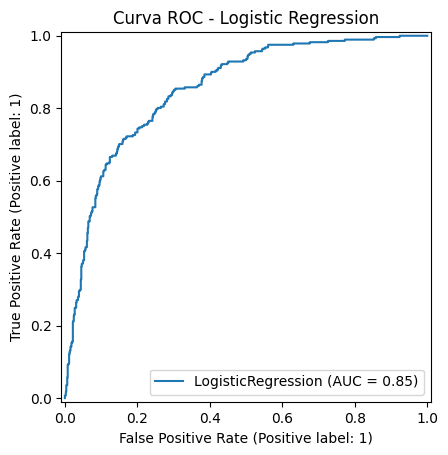


‚ñ∂ Random Forest (ajustada)
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       774
           1       0.67      0.49      0.57       281

    accuracy                           0.80      1055
   macro avg       0.75      0.70      0.72      1055
weighted avg       0.79      0.80      0.79      1055

Matriz de confusi√≥n:
[[704  70]
 [142 139]]
AUC-ROC: 0.8485


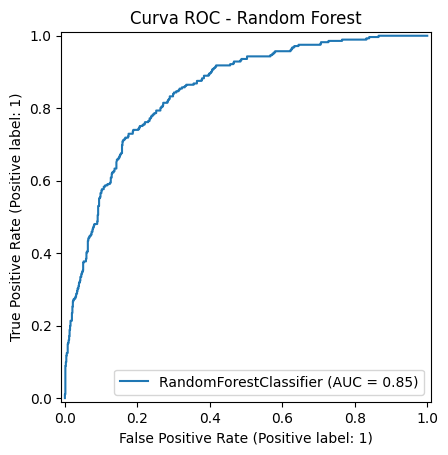


‚ñ∂ XGBoost (ajustado)
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       774
           1       0.68      0.51      0.58       281

    accuracy                           0.81      1055
   macro avg       0.76      0.71      0.73      1055
weighted avg       0.80      0.81      0.80      1055

Matriz de confusi√≥n:
[[707  67]
 [138 143]]
AUC-ROC: 0.8515


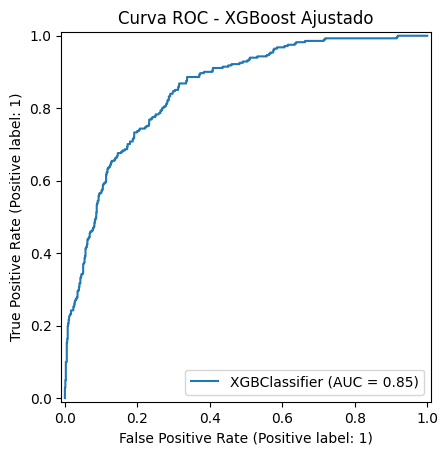

In [47]:
# Carpeta para guardar gr√°ficas
output_folder = "../Visuals/models_ajustados"

# Logistic Regression
best_lr = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=5000, random_state=42)
best_lr.fit(X_train, y_train)
y_pred_lr = best_lr.predict(X_val)
y_prob_lr = best_lr.predict_proba(X_val)[:, 1]
print("‚ñ∂ Logistic Regression (ajustada)")
print(classification_report(y_val, y_pred_lr))
print("Matriz de confusi√≥n:")
print(confusion_matrix(y_val, y_pred_lr))
print(f"AUC-ROC: {roc_auc_score(y_val, y_prob_lr):.4f}")
RocCurveDisplay.from_estimator(best_lr, X_val, y_val)
plt.title("Curva ROC - Logistic Regression")
plt.savefig(os.path.join(output_folder, 'Curva_ROC_Logistic_Adjusted'), dpi=300)
plt.show()
# Random Forest 
best_rf = RandomForestClassifier(
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_val)
y_prob_rf = best_rf.predict_proba(X_val)[:, 1]
print("\n‚ñ∂ Random Forest (ajustada)")
print(classification_report(y_val, y_pred_rf))
print("Matriz de confusi√≥n:")
print(confusion_matrix(y_val, y_pred_rf))
print(f"AUC-ROC: {roc_auc_score(y_val, y_prob_rf):.4f}")
RocCurveDisplay.from_estimator(best_rf, X_val, y_val)
plt.title("Curva ROC - Random Forest")
plt.savefig(os.path.join(output_folder, 'Curva_ROC_RF_Adjusted'), dpi=300)
plt.show()
# XGBoost 
best_xgb = XGBClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    eval_metric='logloss',
    random_state=42
)
best_xgb.fit(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_val)
y_prob_xgb = best_xgb.predict_proba(X_val)[:, 1]
print("\n‚ñ∂ XGBoost (ajustado)")
print(classification_report(y_val, y_pred_xgb))
print("Matriz de confusi√≥n:")
print(confusion_matrix(y_val, y_pred_xgb))
print(f"AUC-ROC: {roc_auc_score(y_val, y_prob_xgb):.4f}")
RocCurveDisplay.from_estimator(best_xgb, X_val, y_val)
plt.title("Curva ROC - XGBoost Ajustado")
plt.savefig(os.path.join(output_folder, 'Curva_ROC_XGB_Adjusted'), dpi=300)
plt.show()

## 18. Comparaci√≥n de modelos ajustados  
Se comparan los tres (3) modelos con sus respectivas m√©tricas claves  

üîé Comparaci√≥n de Modelos Ajustados:



Modelo  Accuracy  F1 Score (Churn)   AUC ROC
0  Logistic Regression  0.822749          0.642447  0.853033
1        Random Forest  0.799052          0.567347  0.848541
2              XGBoost  0.805687          0.582485  0.851550

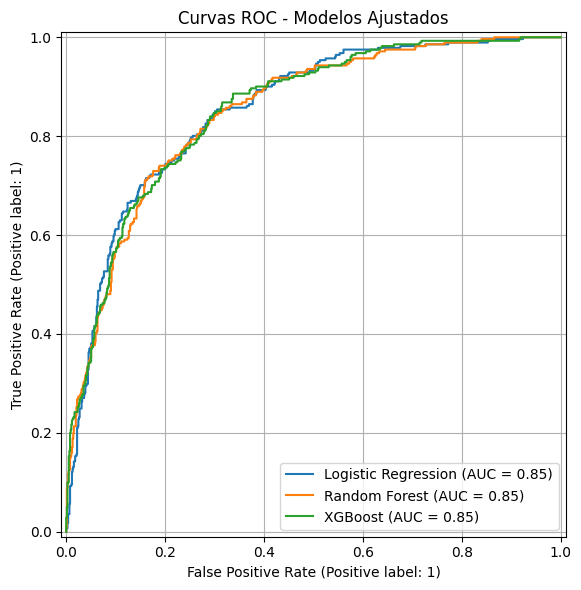

In [48]:
# Carpeta para guardar gr√°ficas
output_folder = "../Visuals/models_ajustados"

# Predicciones y m√©tricas - Logistic Regression
y_pred_lr = best_lr.predict(X_val)
y_prob_lr = best_lr.predict_proba(X_val)[:, 1]
acc_lr = accuracy_score(y_val, y_pred_lr)
f1_lr = f1_score(y_val, y_pred_lr)
auc_lr = roc_auc_score(y_val, y_prob_lr)
# Predicciones y m√©tricas - Random Forest
y_pred_rf = best_rf.predict(X_val)
y_prob_rf = best_rf.predict_proba(X_val)[:, 1]
acc_rf = accuracy_score(y_val, y_pred_rf)
f1_rf = f1_score(y_val, y_pred_rf)
auc_rf = roc_auc_score(y_val, y_prob_rf)
# Predicciones y m√©tricas - XGBoost
y_pred_xgb = best_xgb.predict(X_val)
y_prob_xgb = best_xgb.predict_proba(X_val)[:, 1]
acc_xgb = accuracy_score(y_val, y_pred_xgb)
f1_xgb = f1_score(y_val, y_pred_xgb)
auc_xgb = roc_auc_score(y_val, y_prob_xgb)
# Tabla comparativa
resultados_comparacion = pd.DataFrame({
    "Modelo": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [acc_lr, acc_rf, acc_xgb],
    "F1 Score (Churn)": [f1_lr, f1_rf, f1_xgb],
    "AUC ROC": [auc_lr, auc_rf, auc_xgb]
})
print("üîé Comparaci√≥n de Modelos Ajustados:\n")
display(resultados_comparacion)
# Curvas ROC
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_val, y_prob_lr, name="Logistic Regression", ax=plt.gca())
RocCurveDisplay.from_predictions(y_val, y_prob_rf, name="Random Forest", ax=plt.gca())
RocCurveDisplay.from_predictions(y_val, y_prob_xgb, name="XGBoost", ax=plt.gca())
plt.title("Curvas ROC - Modelos Ajustados")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'Curvas_ROC_Modelos_Ajustados'), dpi=300)
plt.show()

## 19. Validaci√≥n Cruzada  
Implementaci√≥n de la Validaci√≥n Cruzada para asegurar la robustez de los modelos. 

In [2]:
from sklearn.model_selection import cross_validate

# Diccionario con los modelos ajustados
modelos_ajustados = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'XGBoost': best_xgb,
    'Decision Tree': best_tree  # Incluimos el √°rbol ajustado
}

# M√©tricas a evaluar
metricas = ['accuracy', 'f1', 'roc_auc']

# Lista para almacenar los resultados
resultados_cv = []

# Evaluaci√≥n con validaci√≥n cruzada
for nombre, modelo in modelos_ajustados.items():
    scores = cross_validate(modelo, X_train, y_train, scoring=metricas, cv=5)
    resultados_cv.append({
        'Modelo': nombre,
        'Accuracy': scores['test_accuracy'].mean(),
        'F1 Score (Churn)': scores['test_f1'].mean(),
        'AUC ROC': scores['test_roc_auc'].mean()
    })

# Convertimos a DataFrame
df_resultados_cv = pd.DataFrame(resultados_cv)
df_resultados_cv = df_resultados_cv.sort_values(by='AUC ROC', ascending=False).reset_index(drop=True)

# Mostramos resultados
print("‚úÖ Resultados con Validaci√≥n Cruzada (CV=5):\n")
display(df_resultados_cv)

# Guardamos a CSV
df_resultados_cv.to_csv("../Reports/resultados_finales.csv", index=False)


NameError: name 'best_lr' is not defined

In [50]:
# Diccionario con los modelos ajustados
modelos_ajustados = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'XGBoost': best_xgb
}
# M√©tricas a evaluar
metricas = ['accuracy', 'f1', 'roc_auc']
# DataFrame para almacenar los resultados
resultados_cv = []
for nombre, modelo in modelos_ajustados.items():
    scores = cross_validate(modelo, X_train, y_train, scoring=metricas, cv=5)
    resultados_cv.append({
        'Modelo': nombre,
        'Accuracy': scores['test_accuracy'].mean(),
        'F1 Score (Churn)': scores['test_f1'].mean(),
        'AUC ROC': scores['test_roc_auc'].mean()
    })
# Convertimos a DataFrame
df_resultados_cv = pd.DataFrame(resultados_cv)
print(" Resultados con Validaci√≥n Cruzada (CV=5):\n")
display(df_resultados_cv)
df_resultados_cv.to_csv("../Reports/resultados_finales.csv")

 Resultados con Validaci√≥n Cruzada (CV=5):



Modelo  Accuracy  F1 Score (Churn)   AUC ROC
0  Logistic Regression  0.800285          0.594405  0.848401
1        Random Forest  0.802518          0.577857  0.845503
2              XGBoost  0.806175          0.593308  0.849374

## 20. Modelos Finales  
Se guardan los Modelos Finales en su respectiva carpeta

In [51]:
#  Guardar el modelo
joblib.dump(best_lr, "../Models/modelos_finales/logistic_regression_model_final.pkl")
joblib.dump(best_rf, "../Models/modelos_finales/rf_model_final.pkl")
joblib.dump(best_xgb, "../Models/modelos_finales/xgb_model_final.pkl")
print(" Modelos finales guardados correctamente.")

 Modelos finales guardados correctamente.


## 21. An√°lisis y Recomendaciones  
### Modelos Probados
1. Se implementaron y ajustaron tres algoritmos de clasificaci√≥n para predecir la p√©rdida de clientes (churn):
- Regresi√≥n Log√≠stica
- Random Forest
- XGBoost (Gradient Boosting)
2. Cada modelo fue evaluado utilizando validaci√≥n cruzada con 5 particiones (CV=5) y se ajustaron sus hiperpar√°metros para maximizar el F1-Score, dada la importancia de balancear precisi√≥n y recall en casos de desbalance de clases como este.
3. XGBoost obtuvo el mejor desempe√±o general, destacando ligeramente en Accuracy y AUC ROC. Su naturaleza de ensemble y capacidad para modelar relaciones no lineales complejas lo hacen m√°s robusto frente a datos tabulares como este.
4. Regresi√≥n Log√≠stica tuvo un rendimiento competitivo, especialmente en F1 Score, lo que lo convierte en una buena opci√≥n cuando se necesita interpretar f√°cilmente los coeficientes.
5. Random Forest tambi√©n mostr√≥ buen desempe√±o, aunque con un F1 Score ligeramente menor. Es una excelente alternativa cuando se desea evitar overfitting y mantener interpretabilidad media.
### Recomendaciones
1. Elegir XGBoost como modelo final para producci√≥n, debido a su mejor rendimiento general y estabilidad con datos complejos. Es altamente configurable y escalable.
2. Mantener la Regresi√≥n Log√≠stica como una alternativa interpretable cuando se requiera explicar las decisiones del modelo a stakeholders no t√©cnicos.
3. Actualizar los modelos peri√≥dicamente con nuevos datos de clientes para mantener la capacidad predictiva. Se sugiere un retrain cada trimestre.
4. Analizar la importancia de variables (ya calculada con Random Forest) para entender qu√© caracter√≠sticas est√°n influyendo m√°s en la p√©rdida de clientes. Esto puede guiar decisiones de negocio o campa√±as de retenci√≥n.
5. Guardar los modelos ya entrenados y registrar sus m√©tricas para auditor√≠a, reproducibilidad y mejora continua.
6. Implementar visualizaciones interactivas (dashboard) con m√©tricas en tiempo real para seguimiento del desempe√±o del modelo y evoluci√≥n del churn.

## 22. Shap  
Se selecciona el modelo con mejor desempe√±o (XGBoost) para interpretar las caracter√≠sticas m√°s importantes, mediante la herramienta Shap.

<Figure size 1000x600 with 0 Axes>

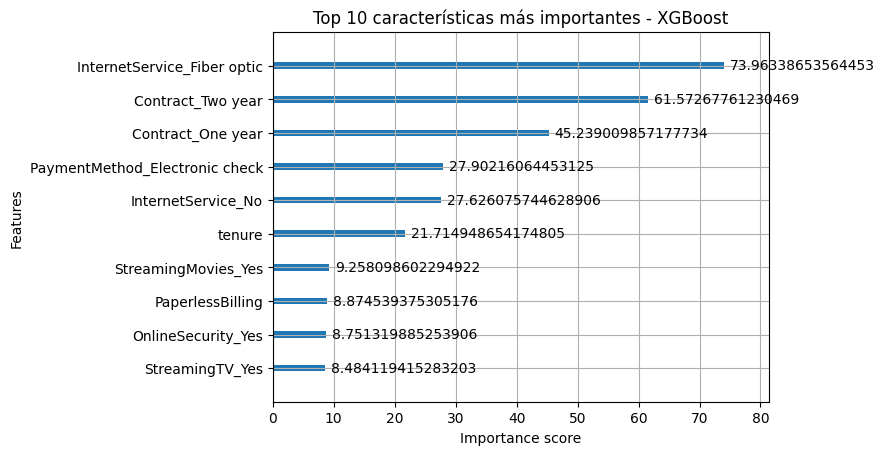

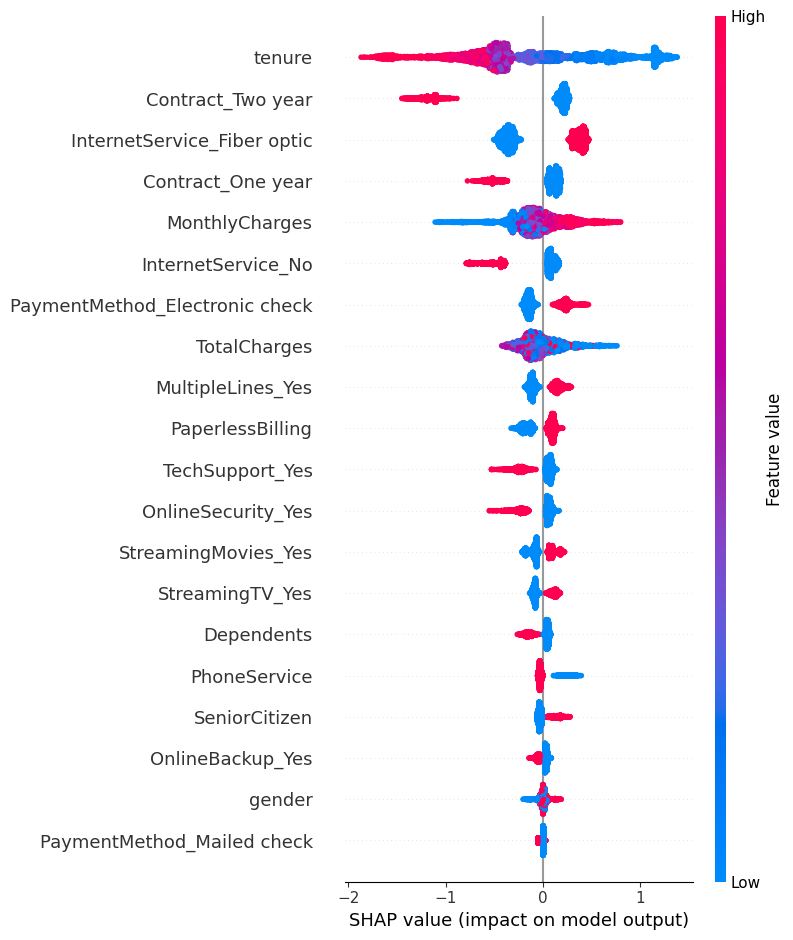

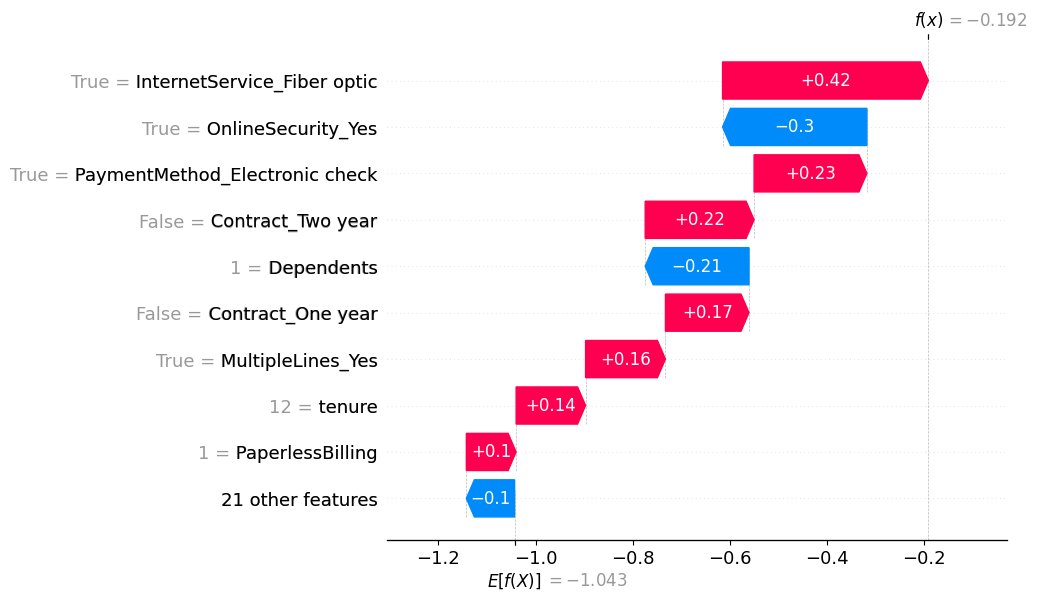

In [ ]:
import shap
from xgboost import plot_importance

# Detecci√≥n autom√°tica del mejor modelo seg√∫n ROC AUC (Test)
best_model = best_xgb if xgb_optimized_results['Test']['roc_auc'] >= xgb_base_results['Test']['roc_auc'] else base_xgb
best_model_name = "Optimizado" if best_model == final_xgb else "Base"
print(f"\nUsando modelo {best_model_name} para an√°lisis de interpretabilidad (mayor AUC-ROC).")

# IMPORTANCIA DE VARIABLES (XGBoost nativa)
plt.figure(figsize=(10, 6))
plot_importance(best_model, max_num_features=10, importance_type='gain')
plt.title(f"Top 10 caracter√≠sticas m√°s importantes - XGBoost ({best_model_name})")
plt.tight_layout()
plt.savefig("../Visuals/shap/top_caracteristic.png")
plt.show()

# SHAP ‚Äì EXPLICACIONES
# Crear explainer
explainer = shap.Explainer(best_model)

# Calcular los valores shap (usa X_train_processed)
shap_values = explainer(X_train_processed)

# GR√ÅFICO RESUMEN SHAP
shap.summary_plot(shap_values, X_train, show=False)  # X_train (sin procesar) para mostrar nombres legibles
plt.savefig("../Visuals/shap/shap_summary.png")
plt.show()

# GR√ÅFICO INDIVIDUAL SHAP (Ejemplo de un solo cliente)
shap.plots.waterfall(shap_values[0], show=False)
plt.savefig("../Visuals/shap/top_shap_waterfall_cliente_0.png")
plt.show()


## 23. Interpretaci√≥n del Modelo con SHAP y Feature Importance  
El modelo XGBoost, seleccionado como el de mejor desempe√±o, fue analizado utilizando t√©cnicas de interpretaci√≥n como SHAP y importancia de caracter√≠sticas por ganancia.

### Las variables que m√°s influyeron en la predicci√≥n del churn fueron:
- InternetService_Fiber optic
- Contract_Two year
- Contract_One year
- PaymentMethod_Electronic check
- Internet service_No
- tenure
- StreamingMovies_Yes
- PaperlessBilling
- OnlineSecurity_Yes
- StreamingTV_Yes

Se observ√≥ que la empresa para predecir el Churn, debe dar importancia a las variables: servicios de Internet, el tipo de contrato, el metodo de pago y los servicios agregados que posee cada cliente.